In [1]:
import json
import pandas as pd
import numpy as np
import os
from pathlib import Path
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [16]:
base_dir = "/workspaces/tcr_structure_embedding/killing_assay/tcrmodel2_out"

yes = ['tcr100','tcr102','tcr107','tcr43','tcr76','tcr475','tcr173','tcr371',
       'tcr425','tcr450','tcr452','tcr149','tcr159','tcr363','tcr374','tcr462',
       'tcr7','tcr168','tcr212','tcr296','tcr177','tcr181','tcr214','tcr20']

no = ['tcr14', 'tcr420', 'tcr520','tcr417']

rows = []
for label, tcr_list in [("yes", yes), ("no", no)]:
    for tcr in tcr_list:
        f = Path(base_dir, tcr, "statistics.json")
        if not f.exists():
            print(f"⚠️ Missing {f}")
            continue
        with open(f, "r") as fh:               # <-- fix: read mode
            all_stats = json.load(fh)

        if "ranked_0" not in all_stats:
            print(f"⚠️ {tcr}: 'ranked_0' missing in {f}")
            continue

        data = dict(all_stats["ranked_0"])      # shallow copy
        data["tcr"] = tcr
        data["label"] = label

        # Optional: expand center_shift vector into scalar columns
        cs = data.pop("center_shift", None)
        if isinstance(cs, (list, tuple)) and len(cs) == 3:
            data["center_shift_x"] = float(cs[0])
            data["center_shift_y"] = float(cs[1])
            data["center_shift_z"] = float(cs[2])

        # Optional: coerce numeric strings (e.g., "IpLDDT": "82.39") to float
        for k, v in list(data.items()):
            if isinstance(v, str):
                try:
                    data[k] = float(v)
                except ValueError:
                    pass

        rows.append(data)

df = pd.DataFrame(rows)
print(f"Loaded {len(df)} TCRs with {df.shape[1]} features")
df.head()


Loaded 28 TCRs with 23 features


,ranking_confidence,plddt,ptm,iptm,tcr-pmhc_iptm,cdr3a_plddt,cdr3b_plddt,IpLDDT,binding_geometry_r,binding_geometry_theta,...,interdomain_angle,cdr1a_plddt,cdr1b_plddt,cdr2a_plddt,cdr2b_plddt,tcr,label,center_shift_x,center_shift_y,center_shift_z
0,0.845528,94.639030,0.872819,0.838705,0.790466,83.335789,89.337871,84.06,29.649289,127.122523,...,107.260147,90.985585,93.362143,94.416999,90.545899,tcr100,yes,2.48727,-0.534601,1.59869
1,0.886037,95.422382,0.904364,0.881456,0.858582,82.744739,92.461607,86.18,30.423737,73.791447,...,109.916038,93.181300,94.866215,95.994684,90.952031,tcr102,yes,6.60636,2.209870,1.67521
2,0.883812,95.093602,0.903183,0.878969,0.855475,83.697149,92.297616,87.83,29.587120,66.379034,...,105.818619,94.505260,92.597144,96.407474,88.716289,tcr107,yes,6.58816,3.008680,2.55832
3,0.803302,94.038908,0.839978,0.794133,0.719256,81.681740,85.979211,81.61,30.009106,115.862575,...,109.965436,89.779871,91.816999,94.191264,89.181992,tcr43,yes,2.79788,-0.064366,1.42018
4,0.835475,94.752025,0.865297,0.828019,0.772051,84.275915,89.894226,84.28,30.066902,105.909456,...,108.957111,92.280065,93.072215,95.551578,89.785196,tcr76,yes,2.90811,0.244673,1.33725


In [19]:
# --- pick numeric features only ---
num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
num_cols = [c for c in num_cols if c not in ["center_shift"]]  # skip vectors

# --- run Mann–Whitney U for each feature ---
stats = []
for col in num_cols:
    yes_vals = df.loc[df.label=="yes", col].dropna()
    no_vals  = df.loc[df.label=="no", col].dropna()
    if len(yes_vals)==0 or len(no_vals)==0:
        continue
    U, p = mannwhitneyu(yes_vals, no_vals, alternative="two-sided")
    med_yes = yes_vals.median()
    med_no  = no_vals.median()
    stats.append({"feature": col, "U": U, "p": p,
                  "median_yes": med_yes, "median_no": med_no,
                  "diff": med_yes - med_no})

stats_df = pd.DataFrame(stats)
stats_df

,feature,U,p,median_yes,median_no,diff
0,ranking_confidence,37.0,0.505397,0.840618,0.858955,-0.018338
1,plddt,39.0,0.590281,93.974908,93.835564,0.139344
2,ptm,37.0,0.505397,0.869274,0.881052,-0.011778
3,iptm,37.0,0.505397,0.833453,0.853431,-0.019978
4,tcr-pmhc_iptm,39.0,0.590281,0.782705,0.815917,-0.033212
5,cdr3a_plddt,50.0,0.924444,78.289396,79.468127,-1.178731
6,cdr3b_plddt,35.0,0.426862,84.077589,85.941171,-1.863582
7,IpLDDT,43.5,0.792821,82.145000,82.830000,-0.685000
8,binding_geometry_r,61.0,0.426862,29.709497,29.034372,0.675125
9,binding_geometry_theta,52.0,0.824811,66.708239,58.698071,8.010167


In [20]:
def perm_test(a, b, stat_func=np.median, n_perm=10000, seed=42):
    """
    Nonparametric permutation test for difference in a statistic between two groups.
    Returns (observed_stat, p-value).
    """
    rng = np.random.default_rng(seed)
    a, b = np.asarray(a, float), np.asarray(b, float)
    obs = stat_func(a) - stat_func(b)
    concat = np.concatenate([a, b])
    n_a = len(a)
    cnt = 1
    for _ in range(n_perm):
        rng.shuffle(concat)
        a_ = concat[:n_a]
        b_ = concat[n_a:]
        if abs(stat_func(a_) - stat_func(b_)) >= abs(obs):
            cnt += 1
    p = cnt / (n_perm + 1)
    return obs, p

# --- pick numeric features only ---
num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]

stats = []
for col in num_cols:
    yes_vals = df.loc[df.label=="yes", col].dropna().to_numpy()
    no_vals  = df.loc[df.label=="no",  col].dropna().to_numpy()
    if len(yes_vals)==0 or len(no_vals)==0:
        continue

    obs_diff, p_perm = perm_test(yes_vals, no_vals, stat_func=np.median, n_perm=10000)
    stats.append({
        "feature": col,
        "median_yes": np.median(yes_vals),
        "median_no": np.median(no_vals),
        "diff": obs_diff,
        "p_perm": p_perm
    })

stats_df2 = pd.DataFrame(stats).sort_values("p_perm")
stats_df2

,feature,median_yes,median_no,diff,p_perm
15,cdr1b_plddt,92.295046,90.846940,1.448106,0.268073
8,binding_geometry_r,29.709497,29.034372,0.675125,0.271073
13,interdomain_angle,106.875488,104.344430,2.531058,0.398260
10,binding_geometry_phi,11.553952,9.755783,1.798170,0.472553
16,cdr2a_plddt,92.279031,89.470376,2.808655,0.518648
6,cdr3b_plddt,84.077589,85.941171,-1.863582,0.652835
14,cdr1a_plddt,88.826192,90.375895,-1.549703,0.656034
9,binding_geometry_theta,66.708239,58.698071,8.010167,0.716928
20,center_shift_z,2.426605,2.108155,0.318450,0.733727
11,docking_angle,52.632400,49.811100,2.821300,0.744526


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata

def mirror_hist_feature(
    df, feature, label_col="label",
    left_label="yes", right_label="no",
    bins="fd",
    color_left="#1f77b4", color_right="#2ca02c",
    alpha=0.85, figsize=(8,3.2), grid=True,
    as_percent=True
):
    """
    Back-to-back horizontal histogram using PROPORTION per group.
    Bars on each side sum to 1 (or 100% if as_percent=True).
    """
    xL = df.loc[df[label_col]==left_label, feature].dropna().to_numpy()
    xR = df.loc[df[label_col]==right_label, feature].dropna().to_numpy()
    if xL.size == 0 or xR.size == 0:
        raise ValueError(f"No data in one group for {feature}")

    # shared bins across both groups
    allx = np.concatenate([xL, xR])
    edges = np.histogram_bin_edges(allx, bins=bins)
    cL, _ = np.histogram(xL, bins=edges)
    cR, _ = np.histogram(xR, bins=edges)

    # proportions per group
    pL = cL / cL.sum() if cL.sum() else cL.astype(float)
    pR = cR / cR.sum() if cR.sum() else cR.astype(float)

    if as_percent:
        pL *= 100.0
        pR *= 100.0
        xlab = "Proportion (%)"
    else:
        xlab = "Proportion"

    centers = 0.5*(edges[:-1] + edges[1:])
    h = edges[1:] - edges[:-1]

    # mean ranks (of pooled values) for annotation
    ranks = rankdata(allx, method="average")
    mean_rank_L = ranks[:xL.size].mean()
    mean_rank_R = ranks[xL.size:].mean()

    fig, ax = plt.subplots(figsize=figsize)

    # left (negative) and right bars
    ax.barh(centers, -pL, height=h, color=color_left, alpha=alpha,
            edgecolor="white", linewidth=0.5, label=left_label)
    ax.barh(centers,  pR, height=h, color=color_right, alpha=alpha,
            edgecolor="white", linewidth=0.5, label=right_label)

    ax.axvline(0, color="k", lw=1)
    if grid:
        ax.grid(axis="x", ls=":", alpha=0.5)

    ax.set_xlabel(xlab)
    ax.set_ylabel(feature)
    ax.set_title(f"{feature}: {left_label} vs {right_label}")

    xmax = max(pL.max() if pL.size else 0, pR.max() if pR.size else 0)
    ax.set_xlim(-1.05*xmax, 1.05*xmax)

    # N and mean-rank annotations
    y_top = centers.max()
    y_pad = 0.06 * (centers.max() - centers.min() + 1e-9)
    ax.text(-0.98*xmax, y_top + y_pad,
            f"N = {xL.size}\nMean Rank = {mean_rank_L:.2f}",
            ha="left", va="bottom", fontsize=9, color=color_left)
    ax.text( 0.98*xmax, y_top + y_pad,
            f"N = {xR.size}\nMean Rank = {mean_rank_R:.2f}",
            ha="right", va="bottom", fontsize=9, color=color_right)

    # “Proportion” labels under each side (optional cosmetic)
    ax_top = ax.twiny(); ax_top.set_xlim(ax.get_xlim()); ax_top.set_xticks([])
    ax.text(-0.5*xmax, centers.min()-3*y_pad, xlab, ha="center", va="top", fontsize=9)
    ax.text( 0.5*xmax, centers.min()-3*y_pad, xlab, ha="center", va="top", fontsize=9)

    ax.legend(frameon=False, loc="upper right")
    plt.tight_layout()
    return fig, ax


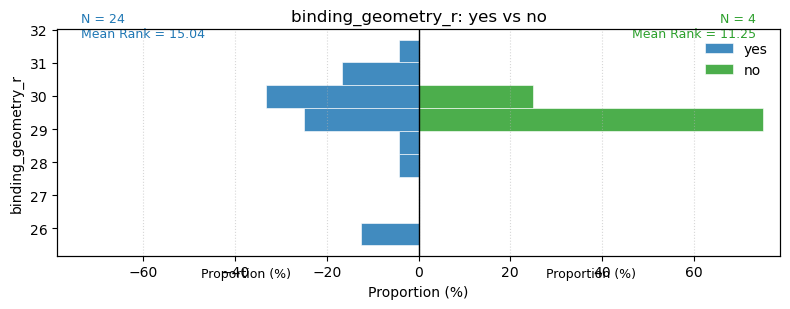

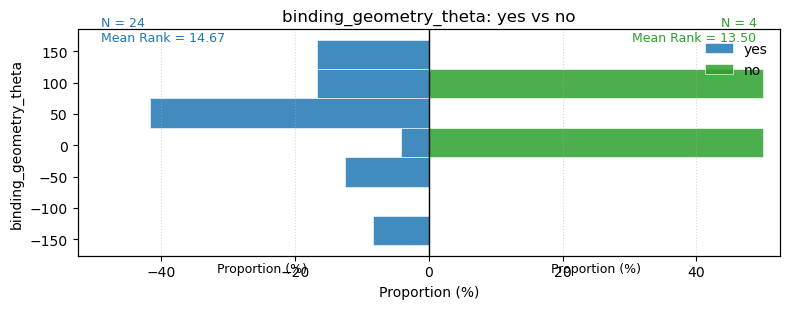

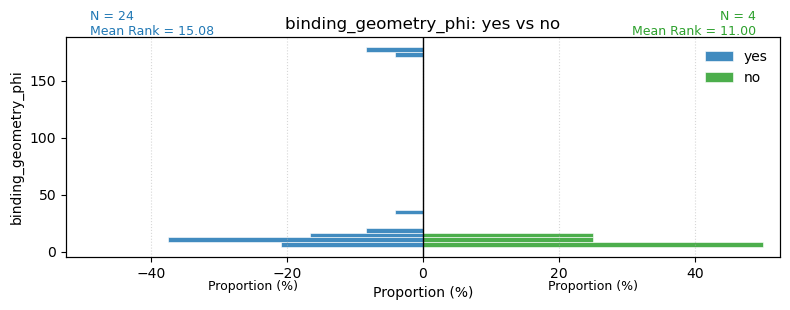

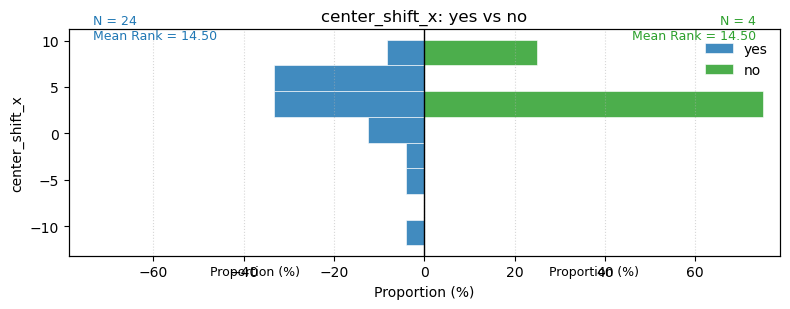

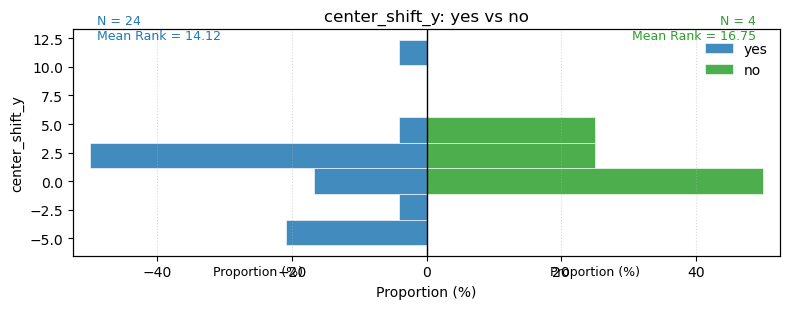

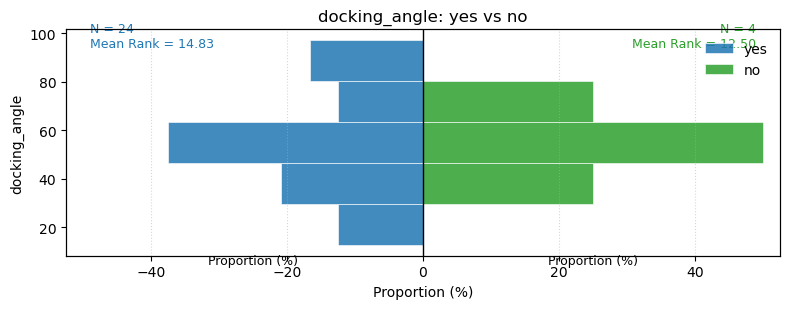

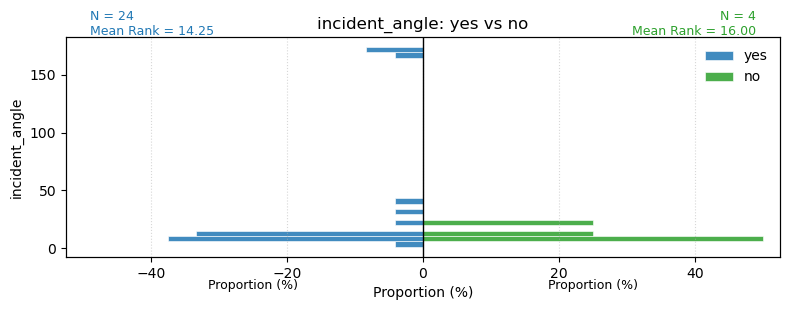

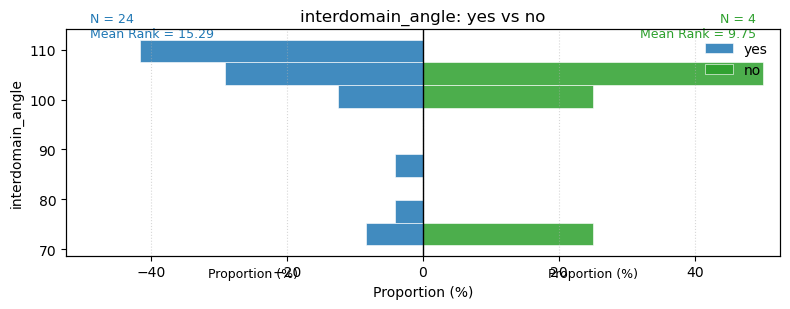

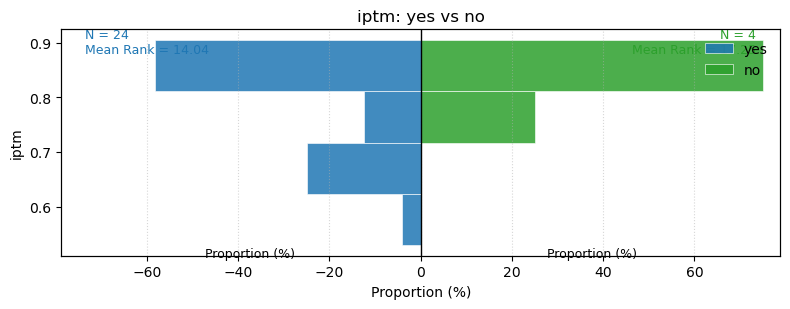

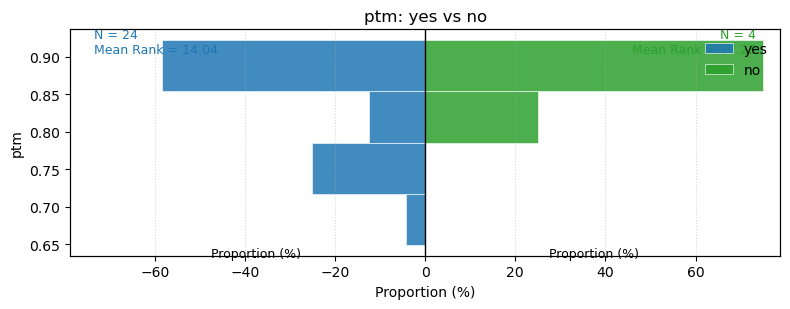

In [26]:
# Loop over several features
features = ["binding_geometry_r","binding_geometry_theta","binding_geometry_phi",
            "center_shift_x","center_shift_y",
            "docking_angle","incident_angle","interdomain_angle",
            "iptm","ptm"
            ]
for feat in features:
    mirror_hist_feature(df, feat)
    plt.show()

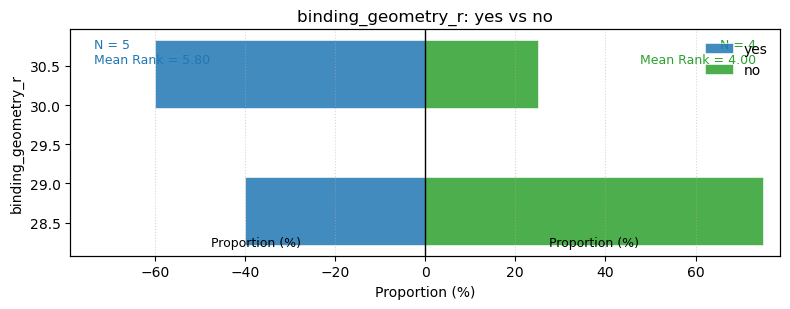

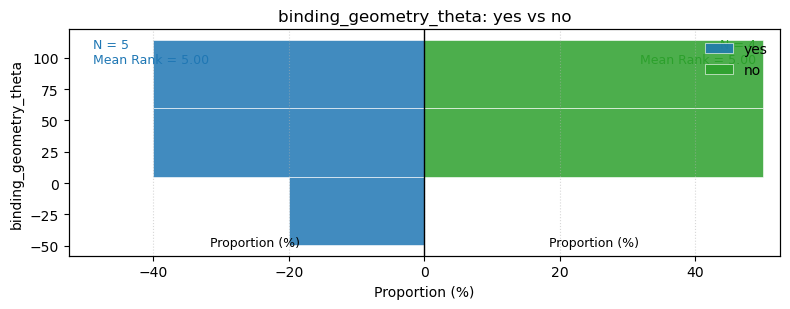

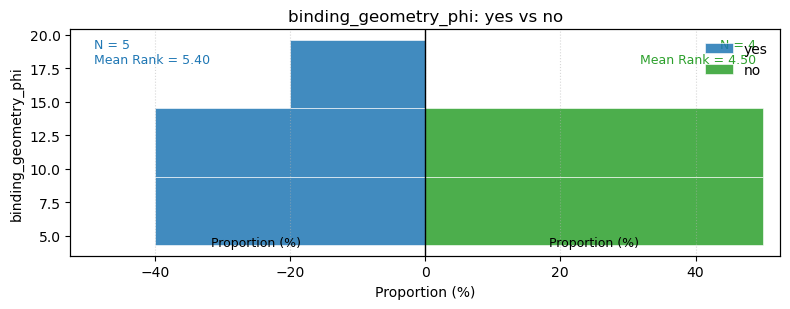

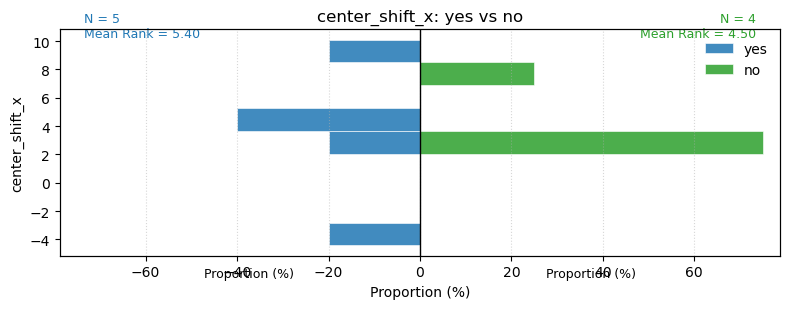

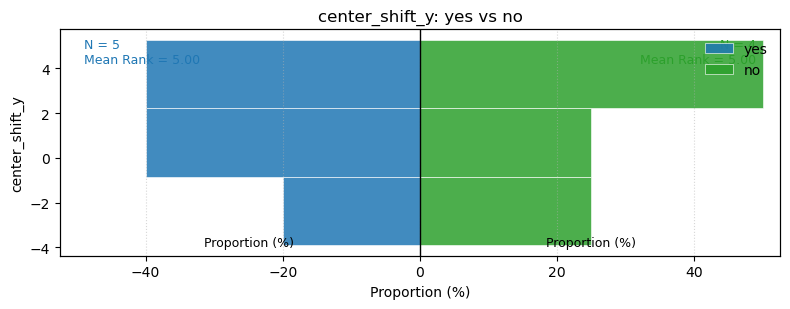

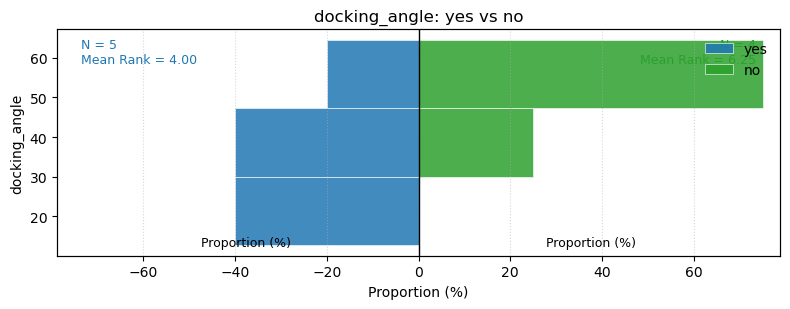

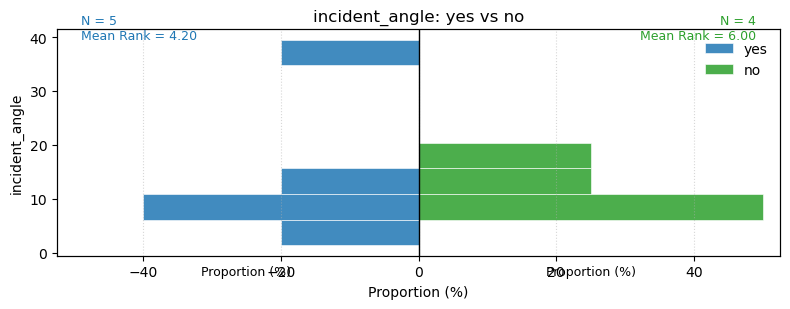

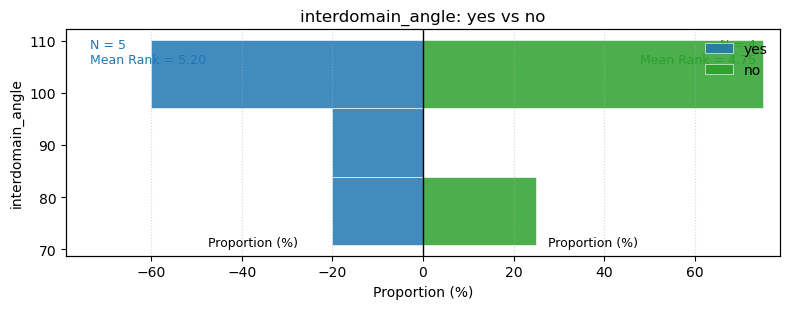

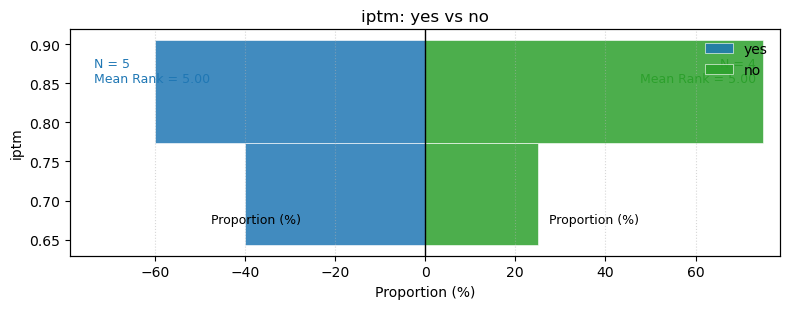

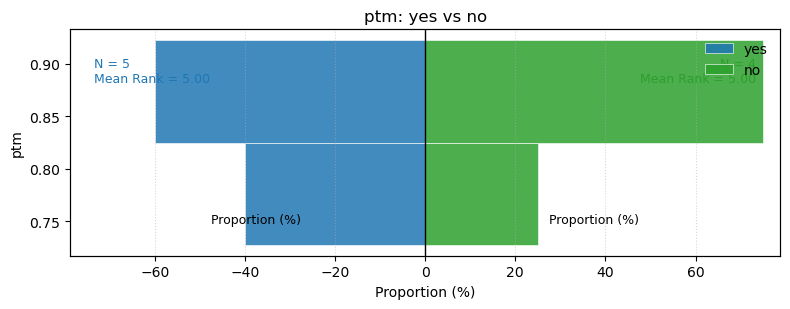

In [29]:
# Loop over several features
features = ["binding_geometry_r","binding_geometry_theta","binding_geometry_phi",
            "center_shift_x","center_shift_y",
            "docking_angle","incident_angle","interdomain_angle",
            "iptm","ptm"
            ]
for feat in features:
    mirror_hist_feature(df[df['tcr'].isin(['tcr363', 'tcr374', 'tcr462','tcr177','tcr181','tcr14', 'tcr420', 'tcr520','tcr417'])], feat)
    plt.show()
